# TD Learning

In this notebook, we will use TD to solve Cliff Walking environment. 

Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/rl/2019/12/29/Tabular-Solution/#td-learning). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/dudeperf3ct/RL_Notebooks/blob/master/TD/TD_CliffWalking.ipynb)

In [0]:
# # We need plotting from lib
# # either upload to colab or google drive

# from google.colab import drive
# drive.mount('/content/drive')
# !cp -a drive/My\ Drive/Colab\ Notebooks/RL_Notebooks/lib /content/

In [0]:
import gym
import matplotlib
import numpy as np
import random
import itertools
import sys
from collections import defaultdict
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')
%matplotlib inline

### CliffWalking Environment

In this environment, we are given start state(x) and a goal state(T) and along the bottom edge there is a cliff(C). The goal is to find optimal policy to reach the goal state. 

An agent can take 4 actions "up", "right", "down", "left" and reward is -1 for all transitions except those into the region marked "C". Stepping into "C" incurs a reward of -100 and send agent instantly back to start.

![cliff_walk](images/cliff_walk.png)


In [0]:
env = CliffWalkingEnv()

In [4]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [0]:
action = ["up", "right", "down", "left"]

In [6]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

Number of states: 48
Number of actions that an agent can take: 4


In [7]:
# Where am I? -> in "x" state
print ("Current state", env.s)
# What are my options? -> 4 action
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [8]:
# Taking a step by selecting a random action[up=0, right=1, down=2, left=3] from current state
# next state: Where do I end up?
# reward: What rewards did I recieve?
# is_terminal: did I end up in the goal state?
# t_prob: What is probability of ending up in next state taking that action?
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -100
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



### SARSA (On-policy)

The goal in sarsa is to find optimal policy.

$$ \begin{aligned} Q(s_{t}, a_{t}) &= Q(s_{t}, a_{t}) + \alpha [R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))]\ \end{aligned} $$

![SARSA](images/sarsa.png)


In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [10]:
%%time 

# generate a episode in cliffwalking environment for above sample_policy
def generate_episode(policy, verbose=False):
    episode = []
    env = CliffWalkingEnv()
    curr_state = env.reset()
    probs = policy(curr_state)
    action = np.random.choice(np.arange(len(probs)), p=probs)
    
    while True:
        if verbose:
            print ("Current observation:")
            print ("Current poistion:", curr_state)
            #print (env.render())
        
        next_obs, reward, is_terminal, _ = env.step(action)
        
        if verbose:
            print ("Action taken:", actions[action])
            print ("Next observation:", next_obs)
            print ("Reward recieved:", reward)
            print ("Terminal state:", is_terminal)
            #print (env.render())
            print ("-"*20)
        episode.append((curr_state, action, reward))
        
        # Pick the next action
        next_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
    
        curr_state = next_obs
        action = next_action

        if (is_terminal):
            break

    return episode
    
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)
e = generate_episode(policy)
#print ("Episode:", e)
print ("Length of episode:", len(e))

Length of episode: 586697
CPU times: user 44.1 s, sys: 319 ms, total: 44.4 s
Wall time: 44.2 s


In [0]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 1
        # Takes a lot a lot lot of time to run
        # ep = generate_episode(policy)
        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]
        
        #     td_target = reward + discount_factor * Q[next_state][next_action]
        #     td_error = td_target - Q[state][action]
        #     Q[state][action] += alpha * td_error

        #     stats.episode_rewards[i_episode] += reward
        #     stats.episode_lengths[i_episode] = t

        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, stats

In [12]:
%%time
Q, stats = sarsa(env, 200)

Episode 200/200.CPU times: user 545 ms, sys: 30.4 ms, total: 575 ms
Wall time: 544 ms


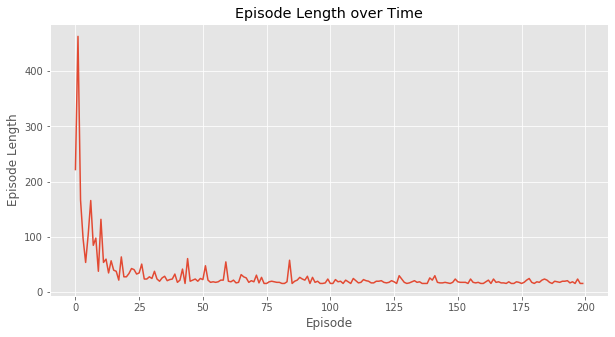

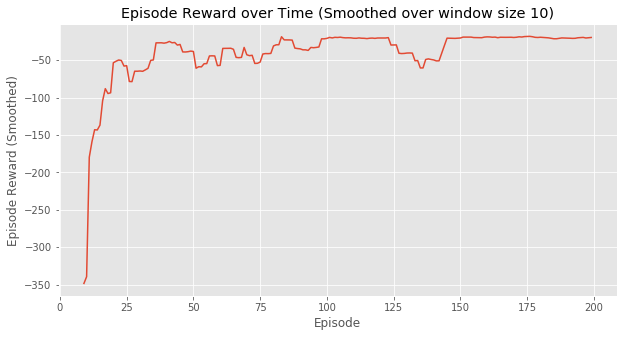

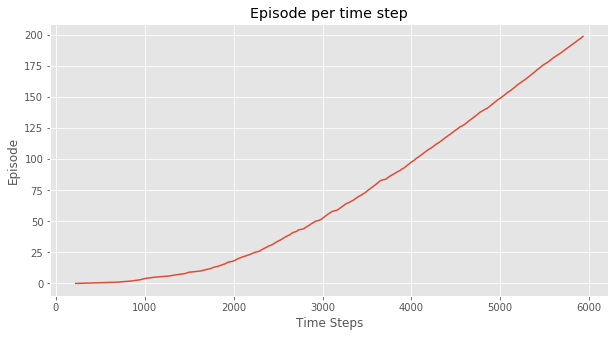

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
plotting.plot_episode_stats(stats)

In [0]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

In [15]:
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  1  1  0  0  1  1  0  1  2]
 [ 0  0  1  0  3  0  0  3  3  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'up' 'up' 'right' 'right' 'up' 'up' 'right' 'right' 'up' 'right'
  'down']
 ['up' 'up' 'right' 'up' 'left' 'up' 'up' 'left' 'left' 'right' 'right'
  'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-15.90385232 -14.67531033 -13.34201405 -12.31405768 -11.69929733
  -10.78860811  -9.1503214   -7.48387682  -6.15989941  -5.03114303
   -4.00574771  -3.00049343]
 [-16.97368456 -16.06568522 -14.75638741 -13.1699256  -12.70618391
  -11.05077916 -11.51235667  -8.42031773  -7.37604038  -6.32110215
   -3.04907774  -2.00000199]
 [-17.98857572 -16.09729106  -9.08582484 -13.40772671 -10.16758344
  -10.02753832  -3.67102051  -3.9541

### Q-Learning

The goal in Q-learning is to find optimal policy while following $\epsilon$-greedy policy.

![QL](images/ql.png)


In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [0]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # Approach : 1
        # Couldn't run this because SARSA never finished :(
        # ep = generate_episode(policy, False)

        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]

        #     best_next_action = np.argmax(Q[next_state])
        #     td_target = reward + discount_factor * Q[next_state][best_next_action]
        #     td_error = td_target - Q[state][action]
        #     Q[state][action] += alpha * td_error

        #     stats.episode_rewards[i_episode] += reward
        #     stats.episode_lengths[i_episode] = t

        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [18]:
%%time
Q, stats = q_learning(env, 500)

Episode 500/500.CPU times: user 263 ms, sys: 31.5 ms, total: 295 ms
Wall time: 261 ms


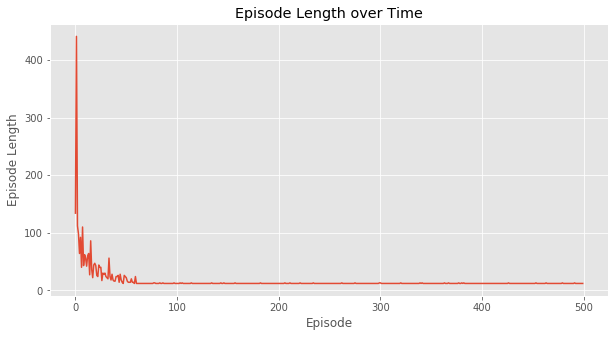

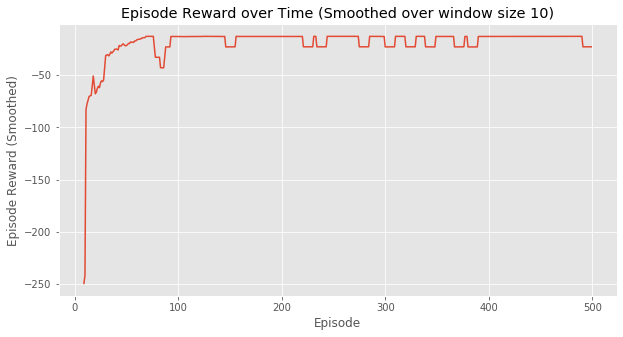

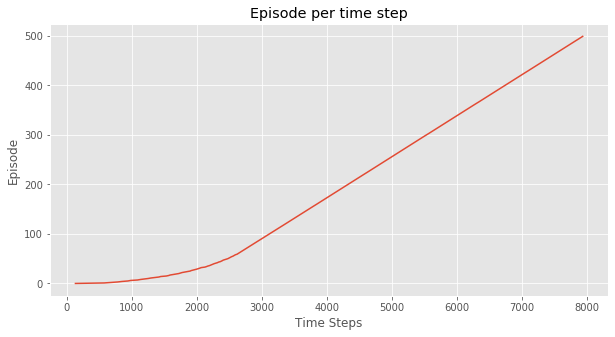

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [19]:
plotting.plot_episode_stats(stats)

In [0]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

In [21]:
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  2  2  1  1  1  2  1  1  2]
 [ 1  1  0  1  3  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'down' 'down' 'right' 'right' 'right' 'down'
  'right' 'right' 'down']
 ['right' 'right' 'up' 'right' 'left' 'right' 'right' 'down' 'right'
  'right' 'down' 'down']
 ['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-11.1339619  -10.628736    -9.95425626  -9.1882717   -8.46938868
   -7.64126222  -6.95511374  -6.18331443  -5.3061077   -4.5489931
   -3.70860939  -2.94821961]
 [-11.36207581 -10.78245174  -9.89770311  -9.14756348  -8.31137949
   -7.51620908  -6.63177683  -5.76088237  -4.84638692  -3.942866
   -2.98186038  -1.99986803]
 [-12.         -11.         -10.          -9.          -8.
   -7.          -6. 